In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, AveragePooling2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import VGG19

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
train_directory='/content/newexample/train'
test_directory='/content/newexample/test'
val_directory='/content/newexample/valid'

In [ ]:
# Load the VGG19 model with pretrained weights
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the pre-trained VGG19 model
for layer in vgg19_model.layers:
    layer.trainable = False

# Create a new Sequential model and add the pre-trained VGG19 model to it
model = Sequential()
model.add(vgg19_model)

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

In [ ]:
# Compile the model with a smaller learning rate
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [ ]:
folders = glob('/content/newexample/train/*')
len(folders)

10

In [ ]:
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_8 (Dense)             (None, 10)                40970     
                                                                 
Total params: 139,611,210
Trainable params: 119,586,826
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation with more aggressive settings
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_directory,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 1601 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
len(training_set), len(test_set)

(51, 2)

In [ ]:
# Use ReduceLROnPlateau callback to reduce learning rate during training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7, verbose=1)

# Use the fit method instead of fit_generator
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=35,  # You can experiment with the number of epochs
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[reduce_lr]
)

Epoch 1/35
51/51 [==============================] - 26s 489ms/step - loss: 2.0470 - accuracy: 0.3379 - val_loss: 0.8813 - val_accuracy: 0.6200 - lr: 1.0000e-04
Epoch 2/35
51/51 [==============================] - 23s 456ms/step - loss: 1.2140 - accuracy: 0.5815 - val_loss: 0.4955 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 3/35
51/51 [==============================] - 25s 492ms/step - loss: 0.9221 - accuracy: 0.6802 - val_loss: 0.3575 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 4/35
51/51 [==============================] - 23s 448ms/step - loss: 0.7793 - accuracy: 0.7295 - val_loss: 0.2577 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 5/35
51/51 [==============================] - 24s 477ms/step - loss: 0.7028 - accuracy: 0.7583 - val_loss: 0.2939 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 6/35
51/51 [==============================] - ETA: 0s - loss: 0.8343 - accuracy: 0.7314
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
51/51 [=======================

In [ ]:
model.save('VGG19model1.h5')

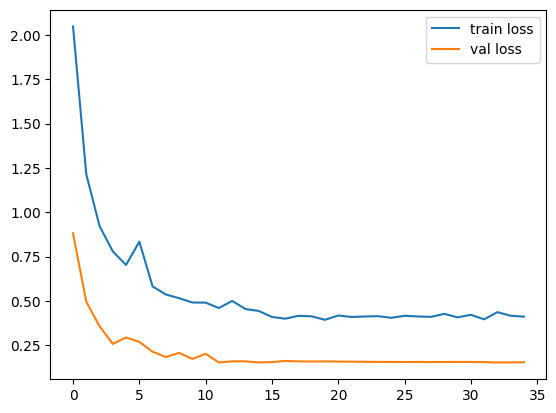

In [ ]:
# Loss
plt.plot(r.history['loss'], label='train loss')
if 'val_loss' in r.history:
    plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

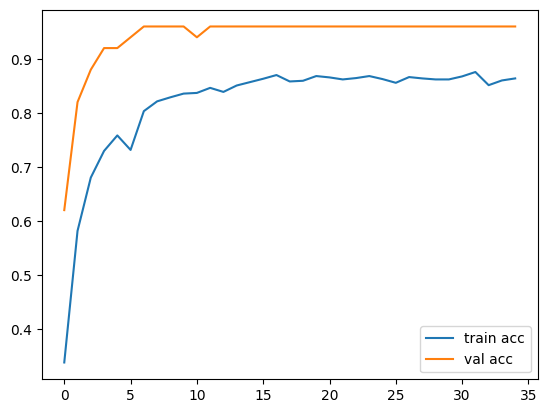

In [ ]:
# Accuracies
plt.plot(r.history['accuracy'], label='train acc')
if 'val_accuracy' in r.history:
    plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

2/2 [==============================] - 1s 188ms/step


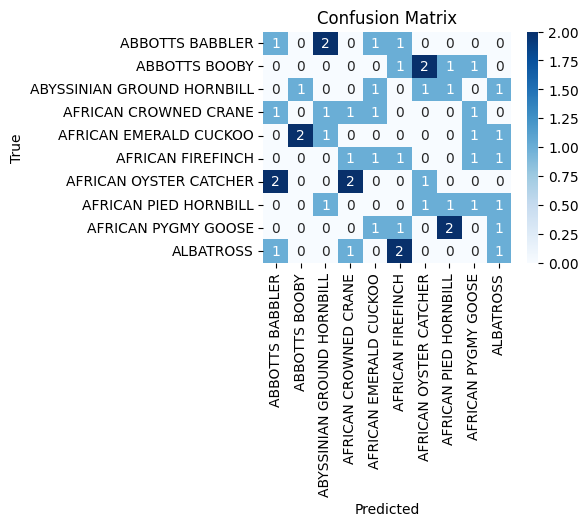

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predicted labels for the test set
Y_true = test_set.classes
Y_pred = model.predict(test_set).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Get class names
class_names = list(test_set.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from keras.layers import Input, Lambda, Dense, Flatten
import tensorflow as tf

model1 = load_model('./VGG19model1.h5',compile=False)

In [ ]:
lab = training_set.class_indices
lab={k:v for v,k in lab.items()}

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    return res

1/1 [==============================] - 0s 272ms/step


'AFRICAN OYSTER CATCHER'

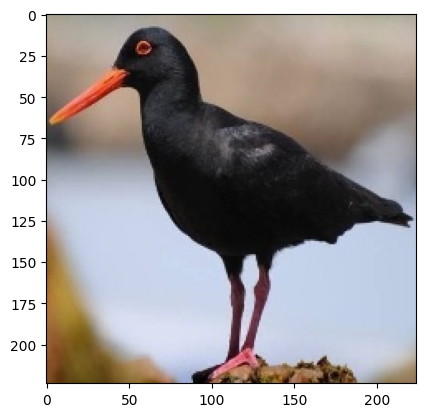

In [ ]:
img='/content/newexample/valid/AFRICAN OYSTER CATCHER/2.jpg'
pic=load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

1/1 [==============================] - 0s 39ms/step


'ABBOTTS BOOBY'

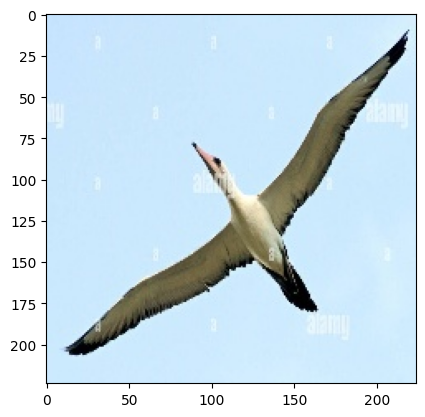

In [ ]:
img='/content/newexample/valid/ABBOTTS BOOBY/3.jpg'
pic=load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)